# Задание №2: Фрактальное сжатие

ФИО: Трифонов Андрей Рафисович 
Группа: 213

**Баллы за задание складываются из двух частей: баллы за выполнение промежуточных подзаданий и баллы за качество**

**Максимальное количество баллов за выполнение промежуточных подзаданий — 15**

**Баллы за качество выставляются по итогам сравнения всех решений**

## Правила сдачи
* У каждого подзадания указано максимальное количество баллов, которые можно за него получить
* Для сдачи необходимо в Google Classroom загрузить Jupyter-ноутбук с выполненными подзаданиями
* В некоторых ячейках есть строки (`# GRADED CELL: [function name]`), эти строки **менять нельзя**, они будет использоваться при проверке вашего решения
* Интерфейс функций и классов помеченных таким образом должен остаться без изменений
* Ячейка со строкой (`# GRADED CELL: [function name]`) должна содержать только **одну функцию или класс**
 * Лайфхак: функции можно определять внутри функций
* Никакие другие ячейки не будут использованы при проверке, они должны быть самодостаточны
* Запрещено импортировать иные библиотеки и функции, кроме указанных в первой ячейке с кодом  
(если сильно захочется что-то еще импортировать, спросите в чате курса)

## GLITCHES

![Segmentation](glitches/attempt_2.jpg)
![Source image](glitches/attempt_3.jpg)
![Segmentation](glitches/corrupted_house.png)
![Segmentation](glitches/first_color_attempt.png)
![Segmentation](glitches/spooky.png)
![Segmentation](glitches/terrifying.png)
![Segmentation](glitches/aaa.png)
![Segmentation](glitches/toxic.png)

In [1]:
# Standard Python Library

import os
import itertools

from collections import namedtuple

# Additional Modules

import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from skimage import data, img_as_float64
from skimage.metrics import mean_squared_error as mse, peak_signal_noise_ratio as psnr
from skimage.transform import resize
from skimage.color import rgb2gray, rgb2yuv, yuv2rgb

from tqdm import tqdm

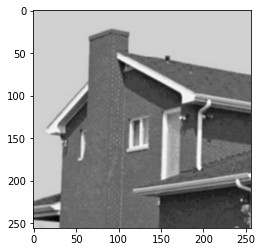

In [2]:
lenna_rgb_512x512 = io.imread('test_files/lenna.bmp')
lenna_rgb_256x256 = resize(lenna_rgb_512x512, (256, 256))
lenna_gray_256x256 = np.rint(rgb2gray(lenna_rgb_256x256) * 255).astype('uint8')

boats_rgb_512x512 = io.imread('test_files/BoatsColor.bmp')
boats_rgb_256x256 = resize(boats_rgb_512x512, (256, 256))
boats_gray_256x256 = np.rint(rgb2gray(boats_rgb_256x256) * 255).astype('uint8')

foxy_rgb_256x256 = io.imread('test_files/foxy_rgb_256x256.jpg')
foxy_gray_256x256 = np.rint(rgb2gray(foxy_rgb_256x256) * 255).astype('uint8')

house_rgb_512x512 = io.imread('images/house.jpg')
house_rgb_256x256 = resize(house_rgb_512x512, (256, 256))
house_gray_256x256 = np.rint(rgb2gray(house_rgb_256x256) * 255).astype('uint8')
plt.imshow(house_gray_256x256, cmap='gray')

## Общие функции
В следующих клетках описаны функции и классы, которые будут использоваться **вами** при выполнении следующих подзаданий. Стоит с ними подробно ознакомиться, понять, что они делают, и поэкспериментировать.

**Не следует их менять.**

In [3]:
def derive_num_bits(length, stride):
    return np.ceil(np.log2(length / stride)).astype(int)

In [4]:
def is_colored(image):
    if len(image.shape) == 2:
        return False
    elif len(image.shape) == 3 and image.shape[-1] == 3:
        return True
    else:
        message = 'Invalid shape of the image: `{}`'
        raise ValueError(message.format(image.shape))

### [4 балла] Функция для нахождения наилучшего преобразования рангового блока

#### Описание

на входе функции подаются:
* исходное Ч/Б изображение (`image`)
* уменьшенное изображение (`resized_image`)
* координаты рангового блока (`x`, `y`)
* размер блока (`block_size`)
* шаг, через сколько пикселей перескакивать при переборе (`stride`)

на выходе функция должна выдавать:
* лучшее преобразование в смысле MSE, объект типа `BlockTransform`

In [30]:
# GRADED CELL: find_block_transform

def find_block_transform(image, resized_image, x, y, block_size=8, stride=1, intensity=0.75):
    '''Find best transformation for given rank block.

    Parameters
    ----------
    image : np.array
        Source B/W image.

    resized_image: np.array
        Resized source image.

    x, y: int, int
        Coordinates of the rank block.
    
    block_size: int
        Size of rank block.

    stride: int
        Vertical and horizontal stride for domain block search.
    
    intensity: float (DEPATCHED)
        Brightness scaling.

    Returns
    -------
    best_transform: BlockTransform
        Best transformation.
    '''
    
    trs = np.arange(8)
    domain_xs = np.arange(0, resized_image.shape[0] - block_size + 1, stride)
    domain_ys = np.arange(0, resized_image.shape[1] - block_size + 1, stride)
    
    def img2domain_blocks(img):
        domain_blocks = []
        
        imgs4trs = np.array([img for tr in trs])
        for tr in range(1, 8):
            imgs4trs[tr] = np.rot90(imgs4trs[tr - 1])
        for tr in range(4, 8):
            imgs4trs[tr] = np.fliplr(imgs4trs[tr])
        
        for tr, dm_x, dm_y in itertools.product(trs, domain_xs, domain_ys):
            domain_blocks.append(imgs4trs[tr][dm_x:(dm_x + block_size),
                                              dm_y:(dm_y + block_size)])
        return domain_blocks
    
    # we may want to have a prebuilt array of domain blocks
    if ((x, y) == (0, 0)):
        find_block_transform.db_cache = img2domain_blocks(resized_image)
    
    domain_blocks = find_block_transform.db_cache # fetch Dij from cache
    rank_block = image[x:(x + block_size), y:(y + block_size)]
    pixels_in_block = block_size * block_size
    
    min_distance = 100000000000
    domain_block_ID = 0
    for tr, dm_x, dm_y in itertools.product(trs, domain_xs, domain_ys):
        domain_block = domain_blocks[domain_block_ID]
        domain_block_ID += 1
        di = (np.sum(rank_block) - intensity * np.sum(domain_block)) / pixels_in_block
        current_distance = np.sum( np.square(domain_block * iy +
                                            di - rank_block) )
        if (current_distance < min_distance):
            min_distance = current_distance
            best_transform = BlockTransform(dm_x, dm_y, (int)(di), tr)
    
    return best_transform

### [4 балла] Применение IFS к изображению

#### Описание

на входе функции подаются:
* исходное изображение (`image`)
* уменьшенное изображение (`resized_image`)
* IFS, массив объектов типа `BlockTransform` (`transforms`)
* размер блока (`block_size`)

на выходе функция должна выдавать:
* картинку после одинарного применения IFS

In [28]:
# GRADED CELL: perform_transform

def perform_transform(image, resized_image, transforms, block_size):
    '''Perform IFS on given image.
    
    Parameters
    ----------
    image : np.array
        Source image.

    resized_image: np.array
        Resized source image.

    transforms: list of BlockTransform's
        Given IFS, Iterated Function System
    
    block_size: int
        Size of rank block.

    Returns
    -------
    transformed_image: np.array
        Transformed image.
    '''
    
    # genrating and image for all 90˚ rotations + mirror
    def img_4_blocks(img):
        trs = np.arange(8) 
        img_and_trs = np.array([resized_image for tr in trs])
        
        for tr in range(1, 8):
            img_and_trs[tr] = np.rot90(img_and_trs[tr - 1])
        for tr in range(4, 8):
            img_and_trs[tr] = np.fliplr(img_and_trs[tr])
            
        return img_and_trs
    
    xs = np.arange(0, image.shape[0], block_size)
    ys = np.arange(0, image.shape[1], block_size)
    
    transformed_image = image
    
    transform_ID = 0
    imgs = img_4_blocks(resized_image)

    for x, y in itertools.product(xs, ys):
        t = transforms[transform_ID]
        transform_ID += 1
        transformed_image[x:(x + block_size),
                          y:(y + block_size)
            ] = 0.75 * imgs[t.tr][t.x:(t.x + block_size), t.y:(t.y + block_size)] + t.di

    return transformed_image

In [27]:
TRANSFORM_UNIT_TESTS = (((np.array([[1, 2], 
                                    [3, 4]]),
                         np.array([[4, 6], 
                                   [8, 10]]),
                         0, 0, 2, 1), 
                        1.5),
                       ((np.array([[1, 2], 
                                   [3, 4]]),
                         np.array([[4, 6, 7, 6], 
                                   [6, 7, 5, 4]]),
                         0, 0, 2, 1), 
                        0),
                       ((np.array([[1, 2], 
                                   [3, 4]]),
                         np.array([[4, 8, 6, 8], 
                                   [6, 7, 5, 8]]),
                         0, 0, 2, 1), 
                        0),
                       ((np.array([[1, 2], 
                                   [3, 4]]),
                         np.array([[4, 2, 3, 6], 
                                   [6, 4, 5, 5]]),
                         0, 0, 2, 2),
                        0.5))
    
    
def test_transform():
    for test, answer in TRANSFORM_UNIT_TESTS:
        transform = find_block_transform(*test)
        img, resized_img, x, y, block_size, stride = test
        transformed = perform_transform(np.zeros_like(img),
                                        resized_img, [transform], block_size)
        loss = mse(img, transformed)
        if loss > answer + 1e-5:
            return False
    return True

print(test_transform())

NameError: name 'iy' is not defined

### [7 баллов] Класс, реализующий интерфейс битового массива
Он понадобится для преобразования найденной IFS в строку, чтобы записать сжатый файл на диск.

In [7]:
# GRADED CELL: BitBuffer

class BitBuffer:
    '''Class that provides storing and and reading integer numbers 
    in continuous bytearray.
    
    !!! BitBuffer is FIFO data structure !!!

    Parameters
    ----------
    buffer : bytearray, optional (default=None)
        Input bytearray, for initialization.

    Attributes
    ----------
    _buffer : bytearray
        Bytearray that can contain any information.

    Examples
    --------
    >>> buffer = BitBuffer()
    >>> buffer.push(1, 1)
    >>> x = buffer.pop(1)
    >>> print(x)
    1
    >>> buffer.push(125, 18)
    >>> x = buffer.pop(18)
    >>> print(x)
    125
    >>> buffer.push(5, 3)
    >>> x = buffer.pop(3)
    >>> print(x)
    5

    >>> dy = transform.y // stride
    >>> buffer.push(dy, self._num_bits_ver)
    '''

    def __init__(self, buffer=None):
        self._buffer = buffer or bytearray()
        # already (written/read) bits by previous (push/pop)
        self._bits2ignore_push = 0
        self._bits2ignore_pop = 0

    def to_bytearray(self):
        '''Convert to bytearray.
    
        Returns
        -------
        buffer: bytearray
            Bytearray that contains all data.
        '''
        
        return self._buffer

    def push(self, x, n_bits):
        '''Push given integer to buffer. (append)
    
        Parameters
        ----------
        x : int
            Input number.

        n_bits: int
            Number of bits for store input number,
            should be greater than log2(x).
        '''
        
        # shift x's bits closer to ending of written bits (b)
        #                         (i i i) <- self._bits2ignore_push (written already)
        # ... | b b b b  b b b b | b b b -  - - - - |
        #                                x  x x 0 0 <- gap_remover (0)
        
        # (gap_remover == 8) <= (self._bits2ignore_push + n_bits == 8 * n), n > 0
        # if so ending will be byte-like
        
        #print("debug dump 4 x=", x)
        gap_remover = 8 - (self._bits2ignore_push + n_bits) % 8 # [0; 8]
        not_byte_sized = 1 if (gap_remover != 8) else 0
        gap_remover %= 8 # preventing 8 bit x shift
        x <<= gap_remover
        
        bytes_to_push = (self._bits2ignore_push + n_bits) // 8 + not_byte_sized
        x = np.int64(x)
        x_bytes = (x.item()).to_bytes(bytes_to_push, byteorder="big", signed=False)
        
        # merge x's first and buffer's last byte
        if (self._bits2ignore_push):
            #print("gap remover:", gap_remover)
            #print("2ignore :", self._bits2ignore_push)
            #print("ending of buffer: ", self._buffer[-1], "; ending of x_bytes: ", x_bytes)
            self._buffer[-1] += x_bytes[0]
            x_bytes = x_bytes[1:] # we dont want to append x's first later
        
        for byte in x_bytes:
            self._buffer.append(byte)
        
        self._bits2ignore_push = (8 - gap_remover) % 8
        
    def pop(self, n_bits):
        '''Pop n_bits from buffer and transform it to a number.
    
        Parameters
        ----------
        n_bits: int
            Number of bits for pop from buffer.

        Returns
        -------
        x: int
            Extracted number.
        '''
        
        #print(self._bits2ignore_pop)
        
        #  (i i i)  <- self._bits2ignore_pop (read already)
        # | ? ? ? x  x x x x | x b b b  b b b b | ...
        # | ? ? ? x  x x x x | x(b b b  b b b b) <- aligner
        # | ? ? ? ?  ? ? ? ? | ? ? x  x x x x x
        
        # (aligner == 8) <= (self._bits2ignore_pop + n_bits == 8 * n), n > 0
        # if so beginning will be byte-like
        
        aligner = 8 - (self._bits2ignore_pop + n_bits) % 8 # [0; 8]
        not_byte_sized = 1 if (aligner != 8) else 0
        aligner %= 8 # preventing 8 bit x shift
        
        bytes_to_pop = (self._bits2ignore_pop + n_bits) // 8
        bytes_to_read = bytes_to_pop + not_byte_sized
        x_bytes = self._buffer[:bytes_to_read]
        
        x = int.from_bytes(x_bytes, byteorder='big', signed=False)
        x >>= aligner
        x &= 2 ** n_bits - 1
        
        self._buffer = self._buffer[bytes_to_pop:]
        self._bits2ignore_pop = (8 - aligner) % 8
        
        return x

In [24]:
def test_bit_buffer():
    def fill():
        bb = BitBuffer()
        bb.push(15, 6)
        bb.push(0, 7)
        bb.push(1, 1)
        bb.push(100, 400)
        answer = [100, 1, 0, 15]
        return bb, answer

    bb, answer = fill()
    res1 = []
    res1.append(bb.pop(400))
    res1.append(bb.pop(1))
    res1.append(bb.pop(7))
    res1.append(bb.pop(6))
    if res1 == answer:
        return True
    bb, answer = fill()
    res2 = []
    res2.append(bb.pop(6))
    res2.append(bb.pop(7))
    res2.append(bb.pop(1))
    res2.append(bb.pop(400))
    if res2 == answer[::-1]:
        return True
    return False

print(test_bit_buffer())

True


### [Баллы за качество] Класс, реализующий интерфейс архиватора изображений

#### Условие
* Класс будет тестироваться как на черно-белых, так и на **цветных** изображениях
* Для цветных изображений необходимо переходить в YUV, сжимать, а потом обратно в RGB для финального результата
* В качестве оценки алгоритма будет использоваться кривая размер-качество, построенная на основе запуска метода compress2, с параметрами качества [0, 20, 40, 60, 80, 100]
* Следует обеспечить непрерывную монотонную зависимость реального качества декодированного изображения от параметра качества
* Баллы будут выставляться исходя из того, насколько построенный график размер-качество лежит близко к верхнему левому углу (высокое качество и низкий размер)
* За красивые графики с равномерно распределенными узлами [0 ... 100] и без точек перегиба выставляются дополнительные баллы
* Ограничение времени работы (суммарно сжатие и разжатие) на всех уровнях качества: 8 минут

**Интерфейсом данного класса считаются только методы compress2 и decompress, остальные можно менять как угодно**`

In [335]:
def domain_info(resized_image):
    block_size = 
    for x, y
    return 0

resized_image = resize(house_gray_256x256, (128, 128), preserve_range=True)
domain_info(resized_image)

0

In [32]:
# GRADED CELL: FractalCompressor

'''
    My types for tests (allowed -- telegram 9:19 29.10)
        BlockTransform:
            x - domain block offset (x)    int
            y - domain block offset (y)    int
            di - brightness scale          int
            iy - intensity scale           int
            neg - for negative intesity    int [0..1]
            tr - symmetry                  int [0..7]
        FractalCompressionParams:
            height - height of image in pixels     int
            width - width of image in pixels       int
            is_colored - rgb or grayscale          int [0, 1]
            min_block_size - min range block size  int
            stride - pixels to skip when searching int
'''
BlockTransform = namedtuple('BlockTransform', ['x', 'y', 'di', 'iy', 'neg', 'tr'])
FractalCompressionParams = namedtuple(
    'FractalCompressionParams', [
        'height',
        'width',
        'is_colored',
        'min_block_size',
        'stride'
    ]
)

class FractalCompressor:
    def __init__(self):
        self._num_bits_ver = None
        self._num_bits_hor = None
        self._num_bits_pix = 10
        self._num_bits_iny = 7
        self._num_bits_tfm = 3
    
    def _add_header(self, buffer, params):
        buffer.push(params.height, 11)
        buffer.push(params.width, 11)
        buffer.push(1 if (params.is_colored) else 0, 1)
        buffer.push(params.min_block_size, 10)
        buffer.push(params.stride, 9)
    
    def _read_header(self, buffer):
        params = FractalCompressionParams(
            buffer.pop(11),
            buffer.pop(11),
            buffer.pop(1) == 1,
            buffer.pop(10),
            buffer.pop(9)
        )
        return params
    
    def _add_to_buffer(self, buffer, transform, stride):
        di_negative_flag = 1 if (transform.di < 0) else 0
        di_unsigned = (abs(transform.di) << 1) + di_negative_flag
        
        buffer.push((int)( (transform.x / stride)  ), self._num_bits_hor)
        buffer.push((int)( (transform.y / stride)  ), self._num_bits_ver)
        buffer.push((int)(  di_unsigned            ), self._num_bits_pix)
        buffer.push((int)(  transform.iy           ), self._num_bits_iny)
        buffer.push((int)(  transform.neg          ), 1                 )
        buffer.push((int)( (transform.tr)          ), self._num_bits_tfm)
        
    def _read_transform(self, buffer, stride):
        x = buffer.pop(self._num_bits_hor) * stride
        y = buffer.pop(self._num_bits_ver) * stride
        di_unsigned = buffer.pop(self._num_bits_pix)
        di = (-1 if (di_unsigned % 2 == 1) else 1) * (di_unsigned >> 1)
        iy = buffer.pop(self._num_bits_iny)
        neg = buffer.pop(1)
        tr = buffer.pop(self._num_bits_tfm)
        transform = BlockTransform (
            x, y, di, iy, neg, tr
        )
        
        return transform
    
    def _quad_tree(self, image, resized_image, min_block_size=4, stride=4):
        # Initial quad tree. (is going to be split by first iteration)
        block_size = image.shape[0] // 2
        sub_block_size = block_size // 2
        rank_coords_pool = [_ for _ in itertools.product([0, block_size], [0, block_size])]
        
        # Make empty quad tree layers.
        threshold = 10000
        levels = np.arange(6)
        def layer_grid(level, initial=None):
            return [[initial for _ in range(2**(level + 2))] for _ in range(2**(level + 2))]
        layers = [layer_grid(l, -1) for l in levels]       # -1 is "ignore rank block" flag
        
        # Generate other handy grids.
        
        def gen_grids(init, dt=int):
            shapes = [(2**(level + 2), 2**(level + 2)) for level in levels]
            return [np.full(shape, init, dtype=dt) for shape in shapes]
        
        distances = gen_grids(10000)
        sums = gen_grids(init=(0,0), dt=(float, 2))
        for r_x, r_y in itertools.product([0, 32, 64, 96], [0, 32, 64, 96]):
            rank_block = image[r_x:(r_x + 32), r_y:(r_y + 32)]
            sums[0][r_x // sub_block_size, r_y // sub_block_size] = (
                np.sum(rank_block, dtype='float64'),
                np.sum(np.square(rank_block, dtype='float64'), dtype='float64')
            )
        
        # DEBUG APPLICATION
        application = (np.copy(image - image)).astype('float64')
        
        # Fill this layers and write 'layers' to buffer
        for level in levels:
            block_size //= 2
            sub_block_size //= 2
            stride = stride if (stride != None) else block_size
            if (block_size == min_block_size):
                thrasholds[level] = 1000000000
            pix_in_block = block_size ** 2
            
            # Neat quad tree split by only adding 3 Rank block offsets to the pool.
            for point in rank_coords_pool.copy():
                rank_coords_pool.append((point[0], point[1] + block_size))
                rank_coords_pool.append((point[0] + block_size, point[1]))
                rank_coords_pool.append((point[0] + block_size, point[1] + block_size))
            
            domain_offsets = np.arange(0, 128 - block_size + 1, stride)
            rank_coords = rank_coords_pool.copy()
            
            if (level != )
            for r_x, r_y in rank_coords:
                # Cut Rank block.
                rank_block = image[r_x:(r_x + block_size), r_y:(r_y + block_size)]
                rank_block = (rank_block).astype('float64')
                
                # Indices for current layer
                c_x, c_y = r_x // block_size, r_y // block_size
                
                # Declare that we realy tried to search for this Rank block.
                layers[level][c_x][c_y] = 0
                
                # Find brightness sums for average error evaluation.
                sums_A[level][c_x][c_y] = np.sum(rank_block, dtype='float64')
                sums_A2[level][c_x][c_y] = np.sum(
                    np.square(rank_block, dtype='float64'), dtype='float64')
                
                ''' CONCEPT -- ROUGH MATHING
                #sum_i = 0
                #s = [0, 0, 0, 0]
                #for i, j in [(0, 0), (0, 1), (1, 0), (1, 1)]:
                #    s[sum_i] = sums_A[level + 1][n_x + i, n_y + j] = np.sum(
                #        rank_block[(r_x + i*sub_block_size):(r_x + (i+1)*sub_block_size),
                #                   (r_y + j*sub_block_size):(r_y + (j+1)*sub_block_size)],
                #            dtype='float64')
                #    sum_i++
                #code_A[level][c_x][c_y] = [s[0] > s[1], s[0] > s[2],
                #                           s[1] > s[3], s[2] > s[3]]
                '''
            
            for d_x, d_y in tqdm(itertools.product(domain_offsets, domain_offsets),
                                 total=len(domain_offsets)*len(domain_offsets)):
                # Cut Domain block.
                domain_block = resized_image[d_x:(d_x + block_size), d_y:(d_y + block_size)]
                domain_block = (domain_block).astype('float64')
                
                # Calculate brightness sums for average error evaluation.
                B = np.sum(domain_block, dtype='float64')
                B2 = np.sum(np.square(domain_block, dtype='float64'), dtype='float64')
                
                # Parse through Rank blocks in this layer's Rank block pool.
                for r_x, r_y in rank_coords:
                    # Cut Rank block. (NOT EFFECTIVE => BETTER HAVE PREBUILT ARRAY)
                    rank_block = image[r_x:(r_x + block_size), r_y:(r_y + block_size)]
                    rank_block = (rank_block).astype('float64')
                    
                    # Indices for 'layers' and 'M_map'
                    l_x = r_x // block_size
                    l_y = r_y // block_size
                    
                    # Fetch brightness sums for average error evaluation.
                    A = sums_A[level][l_x][l_y]
                    A2 = sums_A2[level][l_x][l_y]
                    
                    # Parse through all rotations and 'flections of Domain block.
                    for tr in range(8):
                        # COPMARE BRIGHTNESS CODE HERE -- TODO
                        
                        # The only thing that changes when we rotate is sum(ai * bi)
                        AB = np.sum(np.multiply(
                            domain_block, rank_block,
                            dtype='float64'), dtype='float64')
                        
                        # Evaluate best brightness 'p' and intensity 'q' transformations.
                        q = (pix_in_block * AB - A * B) / (pix_in_block * B2 - B * B)
                        
                        # INTENSITY GUARD
                        q = 0.75 if (q != q) else q # 'q' can be any number.
                        q = 0.99 if (q >= 1.0) else q
                        q = -0.99 if (q <= -1.0) else q
                        q = round(q, 2)
                        
                        p = (A - q * B) / pix_in_block
                        p = round(p)
                        
                        # DEPATCHED 'q' and 'p' FOR DEBUG
                        '''
                        q = 0.75
                        p = (A - 0.75 * B) / pix_in_block
                        p = round(p, 2)
                        M = np.sum(np.square(q * domain_block + p - rank_block,
                                             dtype='float64'), dtype='float64')
                        '''
                        
                        M = q*q*B2 + A2 + pix_in_block*p*p - 2*(q*(AB - p * B) + p*A)
                        
                        # Check if M satisfies criteria
                        first4rank = (r_x, r_y) in rank_coords_pool
                        record_result = (M < map_M[level][l_x][l_y]) or (
                            first4rank and (M < thrasholds[level])
                        )
                        
                        if (record_result):
                            layers[level][l_x][l_y] = BlockTransform(
                                d_x, d_y, int(p), abs(int(q * 100)), 
                                1 if (q < 0) else 0, tr
                            )
                            #application[r_x:(r_x+block_size), 
                            #    r_y:(r_y+block_size)] = q * domain_block + p
                            map_M[level][l_x][l_y] = M
                            
                            if (first4rank):
                                rank_coords_pool.remove((r_x, r_y))
                            
                        # Rotate Domain block
                        domain_block = np.rot90(domain_block)
                        domain_block = domain_block if ((tr + 1) % 4 != 0
                            ) else np.fliplr(domain_block)
                        
        transforms = []
        
        # Write layers of to transforms array.
        for level in levels
            if (level == len(levels) - 1):
                print("Writing pixels")
                #for pixels_x, pixels_y in rank_coords:
                    #print(pixels_x, pixels_y)
                
                break
            elif (level != 0):
                for row in layers[level - 1]:
                    for t in row:
                        if (t == 0):
                            # Not founded.
                            transforms.append(0)
                        elif (t != -1):
                            # Found one.
                            transforms.append(t)
        
        #heat_map = np.rint(np.array(map_M[1])).astype('int')
        #print(application)
        #application = (application).astype('uint8')
        #plt.imshow(application, cmap='gray')
        #print(application)
        #print(transforms)
        
        return transforms
    
    def _disassemble_rgb(self, img_rgb):
        yuv = rgb2yuv(img_rgb)
        yuv = np.rint(yuv * 255)
        yuv[..., 1:] = (yuv[..., 1:] + 128)
        yuv = yuv.clip(0, 255).astype('uint8')
        
        shape_of_uv = ( int(img_rgb.shape[0] * 0.5), int(img_rgb.shape[1] * 0.5) )
        image_u = resize(yuv[...,1], shape_of_uv, preserve_range=True)
        image_v = resize(yuv[...,2], shape_of_uv, preserve_range=True)
        
        return yuv[...,0], image_u, image_v

    def _assemble_rgb(self, img_y, img_u, img_v):
        yuv = np.zeros((256, 256, 3), dtype='uint8')
        restored_shape = (img_y.shape[0], img_y.shape[1])
        img_u = resize(img_u, restored_shape, preserve_range=True)
        img_v = resize(img_v, restored_shape, preserve_range=True)
        yuv[..., 0] = img_y
        yuv[..., 1] = img_u
        yuv[..., 2] = img_v
        
        rgb = yuv.astype('int')
        rgb[..., 1:] = rgb[..., 1:] - 128
        rgb = np.true_divide(rgb, 255).astype('float')
        rgb = np.rint((yuv2rgb(rgb) * 255)).clip(0, 255).astype('uint8')
        
        return rgb
        
    def _compress(self, params, image_y, image_u=None, image_v=None):
        resized_image = resize(image_y, (128, 128), preserve_range=True)
        
        buffer = BitBuffer()
        self._add_header(buffer, params)
        self._num_bits_ver = derive_num_bits(256, params.stride)
        self._num_bits_hor = derive_num_bits(256, params.stride)
        
        transforms = self._quad_tree(image_y, resized_image, params.min_block_size)
        buffer.push(int(len(transforms)), 15)
        for t in transforms:
            if (t == 0):
                buffer.push(0, 1) # Split!
            else:
                buffer.push(1, 1) # Found one.
                self._add_to_buffer(buffer, t, params.stride)
        
        chromas = [image_u, image_v]
        colored = not (image_u is None)
        if (colored):
            for chroma in chromas:
                transforms = self._quad_tree(chroma, resized_image, stride=None)
                buffer.push(int(len(transforms)), 15)
                transform_ID = 0
                for t in transforms:
                    if (t == 0):
                        buffer.push(0, 1) # Split!
                    else:
                        buffer.push(1, 1) # Found one.
                        self._add_to_buffer(buffer, t, params.stride)
                    transform_ID += 1
        
        #print(transforms)
        return buffer.to_bytearray()
        
    def compress2(self, image, quality=50):
        '''Compress input image
        
        Parameters
        ----------
        image : np.array
            Source image.

        quality: int, optional (default=50)
            Quality of image compression

        Returns
        -------
        byte_array: bytearray
            Compressed image.
            
        Note
        ----
        This method must be consistent with `decompress`.
        '''
        #                     0    20    40   60   80  100
        min_block_sizes = [  64,   32,   16,   8,   4,   2]
        params = FractalCompressionParams(
            height = image.shape[0],
            width = image.shape[1],
            is_colored = is_colored(image),
            min_block_size = min_block_sizes[quality//20],
            stride = 4
        )
        
        # IMAGE SIZE GUARD
        if (image.shape[0] != 256):
            image = np.rint(resize(image, (256, 256), preserve_range=True)).astype('uint8')
        
        if (params.is_colored):
            # TODO
            image_y, image_u, image_v = self._disassemble_rgb(image)
            byte_array = self._compress(params, image_y, image_u, image_v)
        else:
            byte_array = self._compress(params, image)
        
        return byte_array
    
    def _perform_transform_qt(self, transforms, min_block_size, image, stride):
        resized_image = resize(image, (128, 128), preserve_range=True)
        levels = [level for level in range(1 + int(np.log2(64 // min_block_size)))]
        
        # Initial quad tree split.
        block_size = image.shape[0] // 2
        rank_coords_pool = [_ for _ in itertools.product(
            [0, block_size], [0, block_size]
        )]
        transform_ID = 0
        
        for level in range(len(levels) + 1):
            block_size //=2
            stride = stride if (stride != None) else block_size
            
            # Neat quad tree split by only adding 3 Rank block offsets to the pool.
            for point in rank_coords_pool.copy():
                rank_coords_pool.append((point[0], point[1] + block_size))
                rank_coords_pool.append((point[0] + block_size, point[1]))
                rank_coords_pool.append((point[0] + block_size, point[1] + block_size))
            
            # Lame, but fine for now.
            rank_coords_pool = sorted(rank_coords_pool, key=lambda x: x[1])
            rank_coords_pool = sorted(rank_coords_pool, key=lambda x: x[0])
            
            rank_coords = rank_coords_pool.copy()
            
            for r_x, r_y in rank_coords:
                if (transforms[transform_ID] != 0):
                    t = transforms[transform_ID]
                    domain_block = resized_image[t.x:(t.x + block_size),
                                                 t.y:(t.y + block_size)]
                    if (t.tr >= 4):
                        domain_block = np.fliplr(domain_block)
                    for tr in range(1, t.tr % 4 + 1):
                        domain_block = np.rot90(domain_block)
                    
                    if (t.neg == 1):
                        image[r_x:(r_x+block_size),
                              r_y:(r_y+block_size)] = (- (t.iy / 100) * domain_block + t.di
                                                      ).clip(0, 255)
                    else:
                        image[r_x:(r_x+block_size),
                              r_y:(r_y+block_size)] = ((t.iy / 100) * domain_block + t.di
                                                      ).clip(0, 255)
                        
                    rank_coords_pool.remove((r_x, r_y))
                    
                transform_ID += 1
                
        return image
    
    def decompress(self, byte_array, num_iters=10):
        '''Decompress input image
        
        Parameters
        ----------
        byte_array: bytearray
            Compressed image.

        num_iters: int, optional (default=10)
            Number of iterations to perform IFS.

        Returns
        -------
        image: np.array
            Decompressed image.
            
        Note
        ----
        This method must be consistent with `compress`.
        '''
        buffer = BitBuffer(byte_array)
        
        params = self._read_header(buffer)
        self._num_bits_ver = derive_num_bits(256, params.stride)
        self._num_bits_hor = derive_num_bits(256, params.stride)
        
        len_of_transforms = buffer.pop(15)
        transforms = []        
        for _ in range(len_of_transforms):
            split_index = buffer.pop(1)
            if (split_index == 1):
                # Proceed transform
                transforms.append(self._read_transform(buffer, params.stride))
            else:
                # Split!
                transforms.append(0)
        
        if (params.is_colored):
            chromas = [0, 0]
            for chroma in range(2):
                len_of_cr_transforms = buffer.pop(15)
                cr_transforms = []
                for _ in range(len_of_cr_transforms):
                    split_index = buffer.pop(1)
                    if (split_index == 1):
                        # Proceed transform
                        # TODO: SPEND LESS BITS ON COLOR!!!
                        cr_transforms.append(self._read_transform(buffer, params.stride))
                    else:
                        # Split!
                        cr_transforms.append(0)
                chromas[chroma] = cr_transforms
        
        image = np.zeros((256, 256), dtype='uint8')
        for _ in range(num_iters):
            image = self._perform_transform_qt(
                transforms, params.min_block_size, image, params.stride
            )
        #print(transforms)
        if (params.is_colored):
            image_y = resize(image, (128, 128), preserve_range=True)
            image_u = self._perform_transform_qt(
                chromas[0], params.min_block_size, np.copy(image_y), None
            )
            image_v = self._perform_transform_qt(
                chromas[1], params.min_block_size, np.copy(image_y), None
            )
            image = self._assemble_rgb(image, image_u, image_v)
        
        return image

In [33]:
comp = FractalCompressor()
out = comp.compress2(foxy_rgb_256x256, quality=80)

  2%|▏         | 20/961 [00:05<03:51,  4.07it/s]<ipython-input-32-d755d5d38d37>:202: RuntimeWarning: invalid value encountered in double_scalars
  q = (pix_in_block * AB - A * B) / (pix_in_block * B2 - B * B)
 38%|███▊      | 6/16 [00:00<00:00, 52.12it/s]

Writing pixels


 31%|███▏      | 5/16 [00:00<00:00, 42.13it/s]

Writing pixels


100%|██████████| 16/16 [00:00<00:00, 19.53it/s]

Writing pixels


In [36]:
plt.imshow(comp.decompress(out, num_iters=10))

IndexError: list index out of range

## Построим график качества
Качество в данном случае будет измеряться по PSNR (а значит в децибелах).

Это базовый график для понимания соотношения между коэффициентом сжатия и качеством, получаемым на выходе. Можно посмотреть, как он будет меняться в зависимости от количества итераций при декомпрессии, например.

In [9]:
def weighted_psnr(ref, img):
    assert ref.shape == img.shape, "Shape mismatch"
    if is_colored(img):
        ref_yuv = rgb2yuv(ref)
        img_yuv = rgb2yuv(img)
        
        return (4 * psnr(ref_yuv[..., 0], img_yuv[..., 0]) +
                    psnr(ref_yuv[..., 1], img_yuv[..., 1]) +
                    psnr(ref_yuv[..., 2], img_yuv[..., 2])
               ) / 6
    else:
        return psnr(ref, img)

In [10]:
quality = [0, 20, 40, 60, 80, 100]

def test_image(img):
    compressed_images = [comp.compress2(img, quality=q) for q in quality]
    decompressed_images = [comp.decompress(compressed) for compressed in compressed_images]
    compression_rates = np.array([len(compressed) for compressed in compressed_images]) / img.size
    psnrs = [weighted_psnr(img, decompressed) for decompressed in decompressed_images]
    return compression_rates, psnrs

In [11]:
def test_and_plot_collection(collection):
    _, ax = plt.subplots(figsize=(8, 6))

    for image in collection:
        compression_rates, psnrs = test_image(image)
        ax.plot(compression_rates, psnrs, marker='o', ms=10, ls='-.')

    ax.set_xlabel('Compression Rate', fontsize=16)
    ax.set_ylabel('PSNR, dB', fontsize=16)

    plt.show()

In [ ]:
test_and_plot_collection([lenna_gray_256x256])

In [ ]:
collection = []
for image_name in os.listdir('test_files'):
    image = resize(io.imread(os.path.join('test_files', image_name)), (256, 256))
    if is_colored(image):
        image = np.rint(rgb2gray(image) * 255).astype('uint8')
    collection.append(image)
test_and_plot_collection(collection)